## L’objectif de ce projet est de créer un modèle de machine learning pour prédire l’approbation d’une demande de carte de crédit. 

In [8]:
# Importation des bibliothèques nécessaires
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

### Chargement du dataset

In [11]:
df = pd.read_csv('cc_approvals.data', header=None, na_values='?')
print("Dimensions du dataset : ", df.shape)

Dimensions du dataset :  (690, 16)


In [13]:

# jettons un coup d'oeil au dataset
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1,f,g,202.0,0,+
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6,f,g,43.0,560,+
2,a,24.50,0.500,u,g,q,h,1.50,t,f,0,f,g,280.0,824,+
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5,t,g,100.0,3,+
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0,f,s,120.0,0,+


## 1. Analyse Exploratoire des données.

### Analyse de la forme des données

In [16]:
df.shape

(690, 16)

##### On a un dataset de 690 lignes et 16 colonnes

NB: il faut savoir que ce dataset est cryptée cùest pourquoi on voit ses valeurs qui n'ont pas de sens !!! 
Avec tout ça j'ai décidé de le garder pour pouvoir sortir du confort des dataset deja prêt et me donner plus de challenge 

<Axes: ylabel='count'>

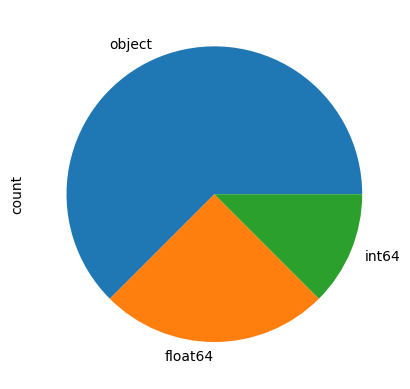

In [19]:
df.dtypes.value_counts().plot.pie()

#### On remarque que la majorite de mes colonnes sont de types object qu'il faudra encoder par la suite

Visualisation des valeurs manquantes de mon dataset a savoir que les "?" signifie NaN dans ce dataset j'ai déjà declarer ceci en chargeant le dataset

<Axes: >

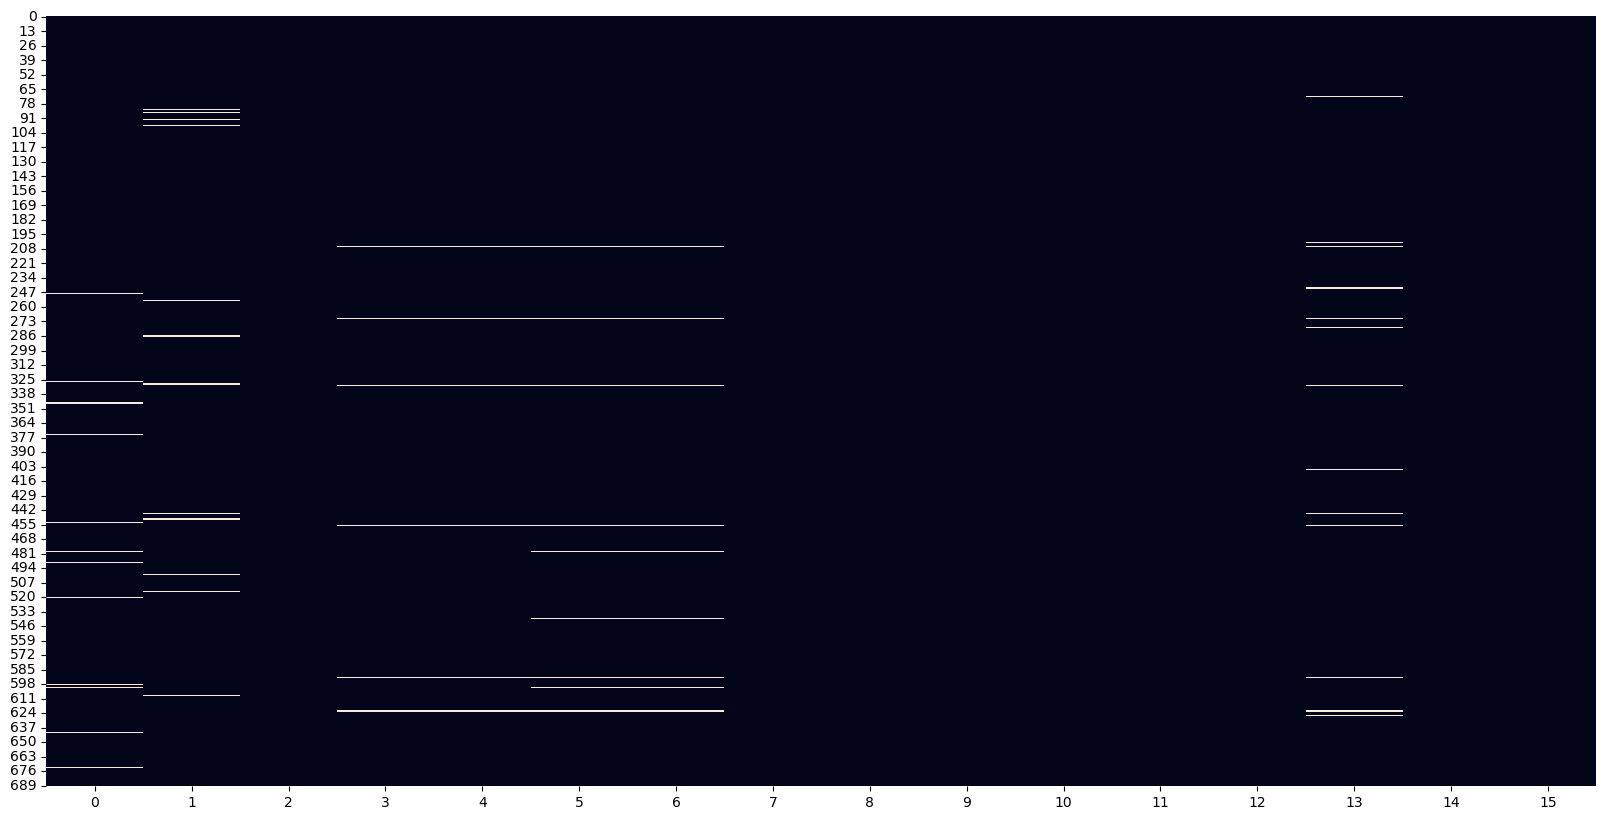

In [23]:
plt.figure(figsize=(20,10))
sns.heatmap(df.isna(), cbar=False)

Tous les lignes blanches represente des valeurs manquantes compartivement a la taille du dataset je dirais que les NaN ne sont pas si nombreuse que ça 

### voyons le pourcnetage de NaN dans chaque colonnes 

In [27]:
(df.isna().sum()/df.shape[0]).sort_values(ascending=True)

2     0.000000
7     0.000000
8     0.000000
9     0.000000
10    0.000000
11    0.000000
12    0.000000
14    0.000000
15    0.000000
3     0.008696
4     0.008696
5     0.013043
6     0.013043
0     0.017391
1     0.017391
13    0.018841
dtype: float64

### Interprétation 

ce qui confirme mes propos car le pourcentage de NaN maximale est inférieure à 2% 

Avant de continuez procedons on nommage de nos colonnes, bien vrai que ce dataset soit crypté, j'ai pu trouvé une description très claire qui m'a beaucoup aidé sur ce site ( https://rstudio-pubs-static.s3.amazonaws.com/73039_9946de135c0a49daa7a0a9eda4a67a72.html )

### on va nommer les colonnes (en se basant sur la documentation du dataset sur le lien mentionné ci-dessus)

In [33]:
df.columns = [
    'Gender', 'Age', 'Debt', 'Married', 'BankCustomer', 'EducationLevel',
    'Ethnicity', 'YearsEmployed', 'PriorDefault', 'Employed', 'CreditScore',
    'DriversLicense', 'Citizen', 'ZipCode', 'Income', 'Approved'
]

Et de là on peut déjà deviner que la colonne Approved est notre colonne Target !

### Voyons une description bref de mes variables numeriques.

In [37]:
df.describe()

,Age,Debt,YearsEmployed,CreditScore,ZipCode,Income
count,678.000000,690.000000,690.000000,690.00000,677.000000,690.000000
mean,31.568171,4.758725,2.223406,2.40000,184.014771,1017.385507
std,11.957862,4.978163,3.346513,4.86294,173.806768,5210.102598
min,13.750000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,22.602500,1.000000,0.165000,0.00000,75.000000,0.000000
50%,28.460000,2.750000,1.000000,0.00000,160.000000,5.000000
75%,38.230000,7.207500,2.625000,3.00000,276.000000,395.500000
max,80.250000,28.000000,28.500000,67.00000,2000.000000,100000.000000


De là on peut dire que:
- la moyenne des ages est autour des 31 ans
- le max des âge est de 80 environs 
- la moyenne du nombres d'années que le client a passé a travaillé  est de 2 ans environs
- le salaire moyen des clients de cette banque est 1017 (dollar probablement) 
- et que le salaire minimum est de 0 et le max est 100 000
- la moyenne des creditScore est de 2,4 avec une valeur maximum de 67
- On peut faire les memes observations pour les autres colonnes ici

In [40]:
df.dtypes

Gender             object
Age               float64
Debt              float64
Married            object
BankCustomer       object
EducationLevel     object
Ethnicity          object
YearsEmployed     float64
PriorDefault       object
Employed           object
CreditScore         int64
DriversLicense     object
Citizen            object
ZipCode           float64
Income              int64
Approved           object
dtype: object

### Traitement des valeurs manquantes

In [399]:
(df.isna().sum()/df.shape[0])

Gender            0.017391
Age               0.017391
Debt              0.000000
Married           0.008696
BankCustomer      0.008696
EducationLevel    0.013043
Ethnicity         0.013043
YearsEmployed     0.000000
PriorDefault      0.000000
Employed          0.000000
CreditScore       0.000000
DriversLicense    0.000000
Citizen           0.000000
ZipCode           0.018841
Income            0.000000
Approved          0.000000
dtype: float64

### Interpretation :
c'est les colonnes :
- Gender, Age, Married, BankCustomer,EducationLevel, Ethnicity, ZipCode qui contiennent des valeurs manquantes ! 

### Suppresion de certains colonnes que je juge inutile 
Je peux me débarrasser des colonnes ZipCode et DriversLicence je ne pense pas qu'ils ont un impacte sur les resultats

In [45]:
df = df.drop(['DriversLicense', 'ZipCode'], axis=1)

### Au lieu de simplement les supprimer, procedons à une Imputation pour gerer ces valeurs manquantes !  

1. pour les colonnes numeriques, je remplace les NaN par la moyenne des valeurs de la colonne si les valeurs sont continue et par le mode si discrète 
2. pour les colonnes de types "objet" ou "Character", je remplace par le mode (c'est a dire la valeur la plus fréquente).

In [49]:
# cas des colonnes numériques et catégorielle
cols = ['Gender',  'Married','BankCustomer','Age']
for col in cols:
   df[col] = df[col].fillna(df[col].mode()[0])

# cas des colones numeriques ( et non categorielle)
for col in df.select_dtypes(include='number'):
    df[col].fillna(df[col].mean())

# Remplacement par la valeur la plus fréquente (mode) pour les colonnes catégorielles
for col in df.select_dtypes(include='object'):
    df[col].fillna(df[col].mode()[0])

# 
df['Ethnicity'] = df['Ethnicity'].fillna(df['Ethnicity'].mode()[0])
df['EducationLevel'] = df['EducationLevel'].fillna(df['EducationLevel'].mode()[0])

### Verifions si l'imputation a réussit

<Axes: >

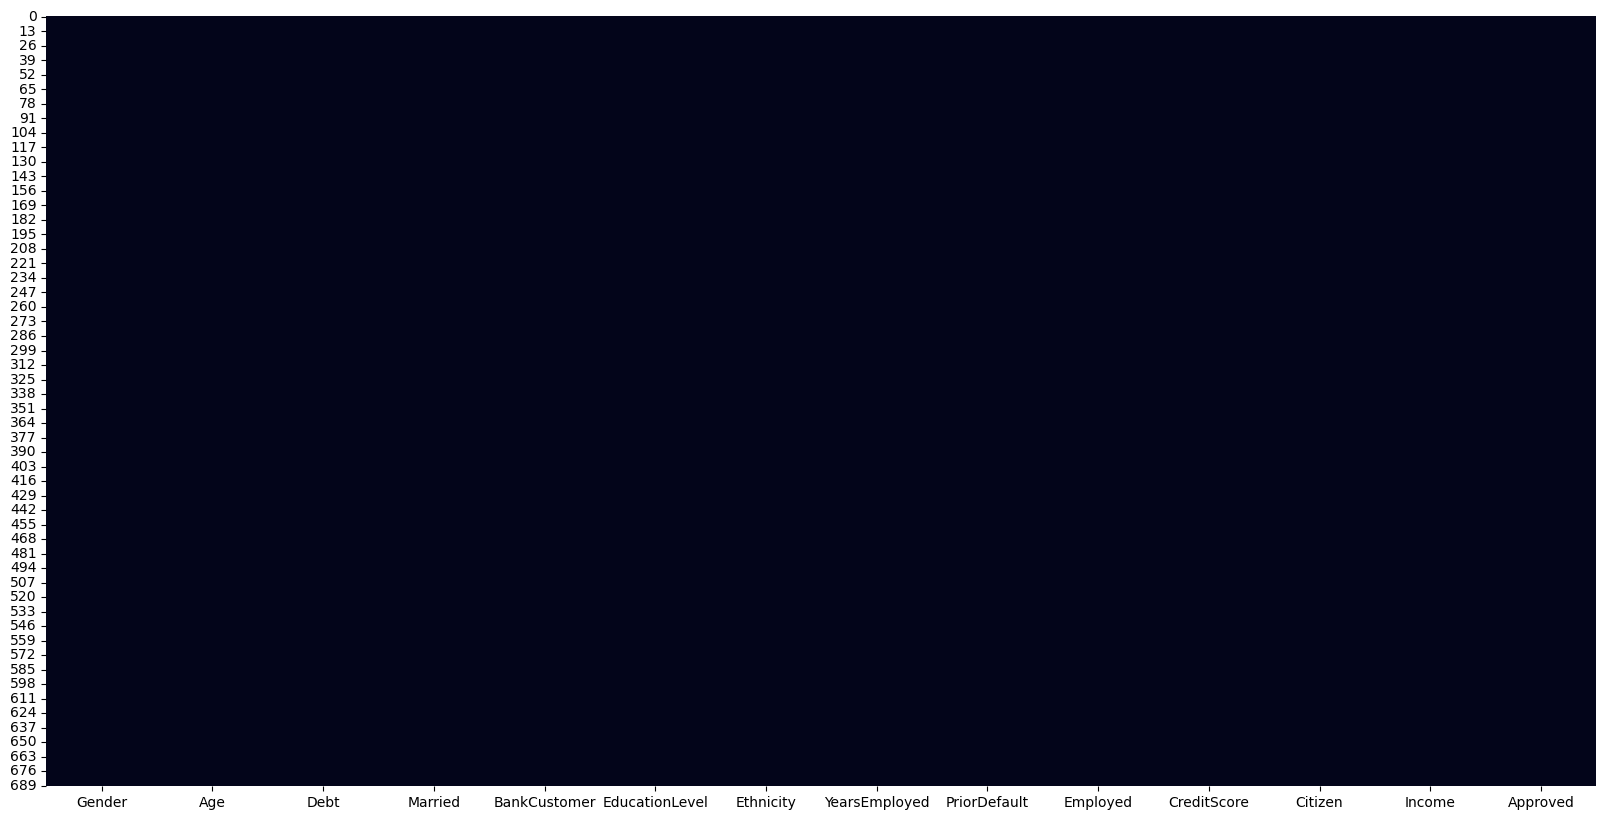

In [54]:
plt.figure(figsize=(20,10)) 
sns.heatmap(df.isna(),cbar=False)

In [410]:
df.shape

(690, 14)

### Interpretation:
on a plus de ligne blanche donc le dataSet ne contient plus de valeurs manquantes

## Encodage

On constate que la majeur partie de nos variables sont de types object (qualitatives) donc on va les encoder en variables numérique. 


### Encodage des variables qualitatives avec labelEncoder

In [60]:
le = LabelEncoder()
for col in df.select_dtypes(include='object'): 
    df[col] = le.fit_transform(df[col])

In [62]:
df.head()

,Gender,Age,Debt,Married,BankCustomer,EducationLevel,Ethnicity,YearsEmployed,PriorDefault,Employed,CreditScore,Citizen,Income,Approved
0,1,30.83,0.000,1,0,12,7,1.25,1,1,1,0,0,0
1,0,58.67,4.460,1,0,10,3,3.04,1,1,6,0,560,0
2,0,24.50,0.500,1,0,10,3,1.50,1,0,0,0,824,0
3,1,27.83,1.540,1,0,12,7,3.75,1,1,5,0,3,0
4,1,20.17,5.625,1,0,12,7,1.71,1,0,0,2,0,0


In [64]:
# Verifons que l'encodage a réussi 
df.dtypes

Gender              int32
Age               float64
Debt              float64
Married             int32
BankCustomer        int32
EducationLevel      int32
Ethnicity           int32
YearsEmployed     float64
PriorDefault        int32
Employed            int32
CreditScore         int64
Citizen             int32
Income              int64
Approved            int32
dtype: object

## Visualisation 

Distribution de la variable cible "Approved"

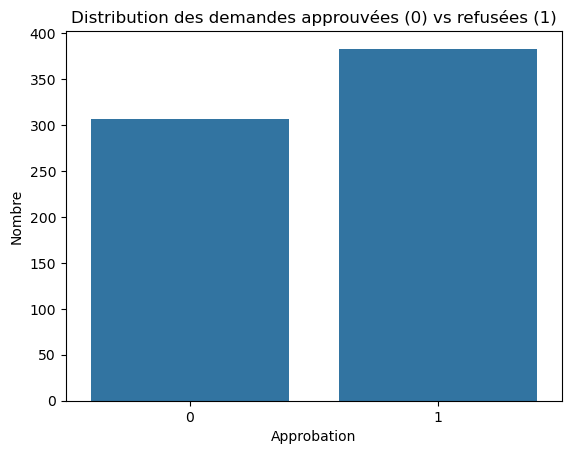

In [68]:
sns.countplot(x='Approved', data=df)
plt.title("Distribution des demandes approuvées (0) vs refusées (1)")
plt.xlabel("Approbation")
plt.ylabel("Nombre")
plt.show()

### Interpretation
On remarque que le nombre de demandes approuvé (0) est inférieur à celles non approuvée  et que nos classes sont légèrement équilibré!!!

### Observation de la distribution de mes variables

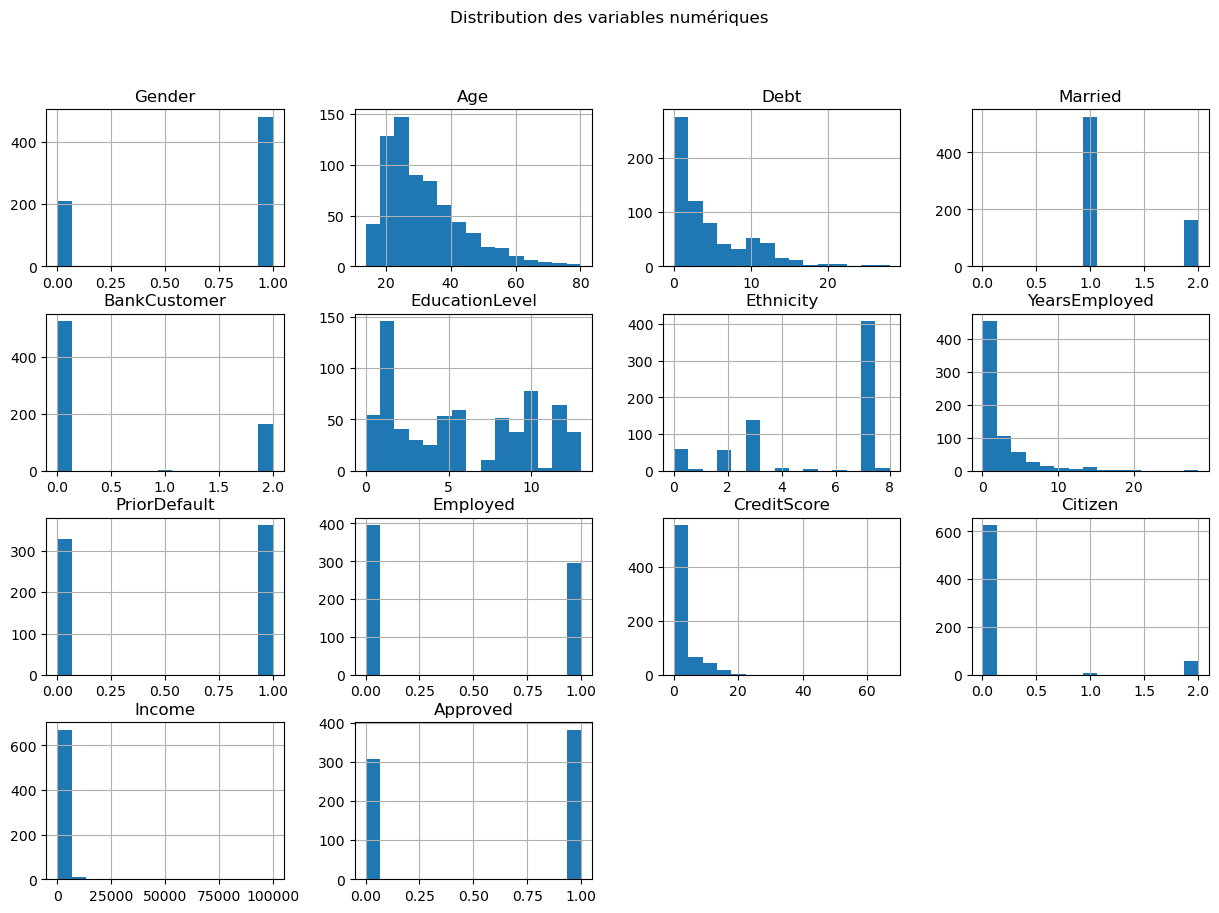

In [428]:
df.select_dtypes(include='number').hist(figsize=(15, 10), bins=15)
plt.suptitle('Distribution des variables numériques')
plt.show()

NB:
- A partir de ces observations on constate quand réalité les colonnes "Married", "BankCustomer" et "Citizen"
ne contiennent pas des variables binaires comme on le croirait donc je vais les rendre binaires par ce que pour moi, ces colonnes doivent être binaires 
- Et ceci va même améliorer les perfomrances du modèle car moins categorie pour certaines variables 

In [73]:
df['Citizen'].unique()

array([0, 2, 1])

In [75]:
df['BankCustomer'].unique()

array([0, 2, 1])

In [77]:
df['Married'].unique()

array([1, 2, 0])

In [79]:
# Remplacer toutes les valeurs ≠ 0 par 1
df['BankCustomer'] = df['BankCustomer'].apply(lambda x: 0 if x == 0 else 1)

# Vérification
print(df['BankCustomer'].unique())


[0 1]


In [81]:
# Ensuite la colonne Married en remplacant les 1 par 0 et les 2 par 1 pour n'avoir que 0 ou 1 
df['Married'] = df['Married'].replace({1: 0, 2: 1, 0: 1})


# Vérification
print(df['Married'].unique())

[0 1]


In [83]:
# pour le cas de Citizen 
df['Citizen'] = df['Citizen'].apply(lambda x: 0 if x == 0 else 1)

# Vérification
print(df['Citizen'].unique())

[0 1]


### Details de l'encodage
- Aprouved: 0 veut dire Approuvé et 1 non approuvé 
- Sexe:  0 femme et 1 homme 
- Married: 0 marié et 1 non marié 
- Citizen: 0 citizen et 1 non Citizen
- Employed: 0 employé et 1 non employé 

Apres ces changements observons une fois de plus la forme des distributiuon de nos variables numeriques.

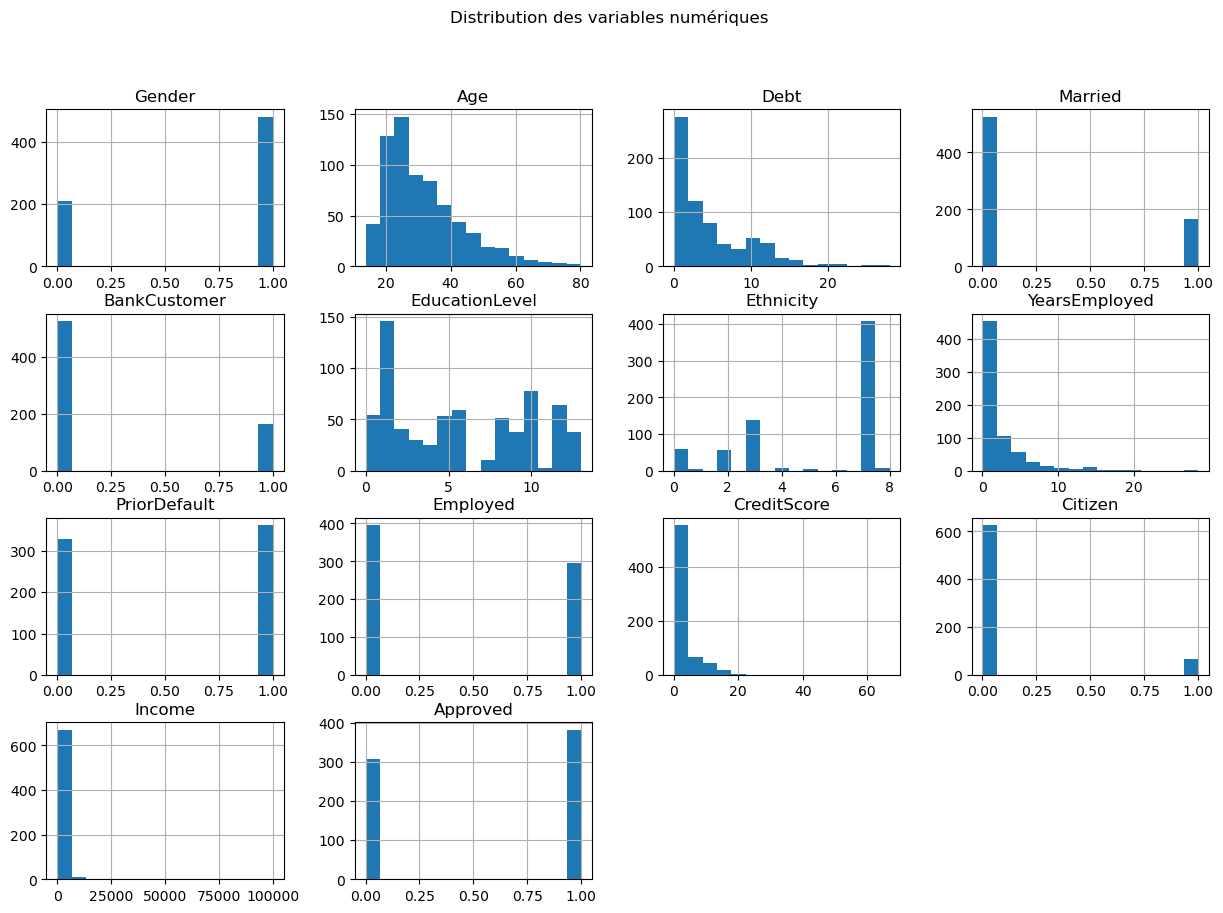

In [87]:
df.select_dtypes(include='number').hist(figsize=(15, 10), bins=15)
plt.suptitle('Distribution des variables numériques')
plt.show()

### Matrice de Corrélation 

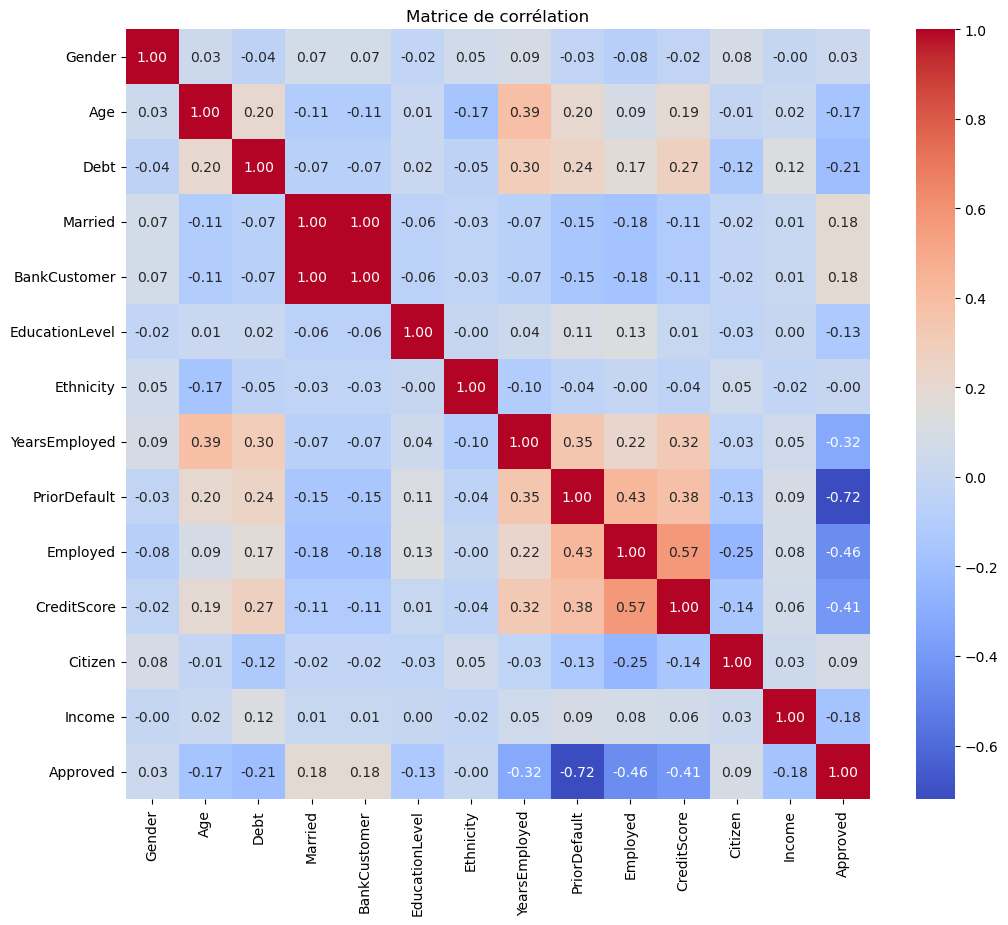

In [90]:
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Matrice de corrélation")
plt.show()

### Interpretation:
- On remarque qu'il ya une correlation de 1 entre la colonne Married et BankCustomer ! 
- Mais attention une forte corelation n/implique une pas une forte dépendance !!! ça ne veut pas dire que dès que tu es client de la banque alors tu es marié 

### Voyons les relations entre mes variables et la variable Traget "Approved"

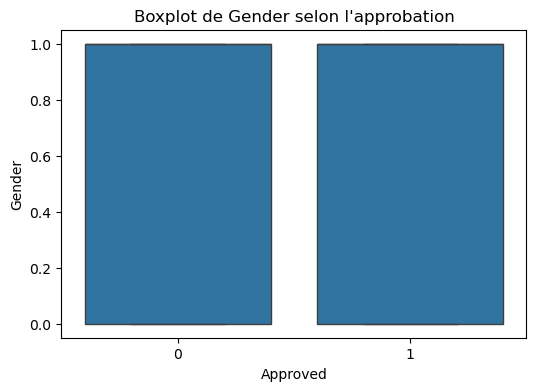

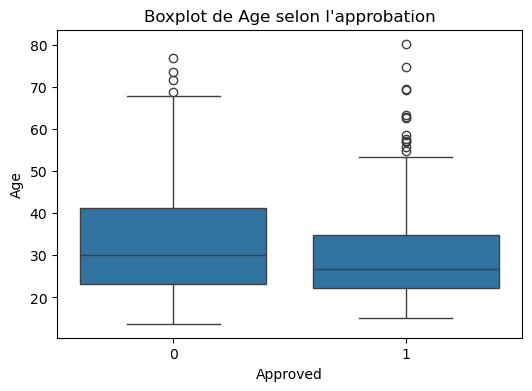

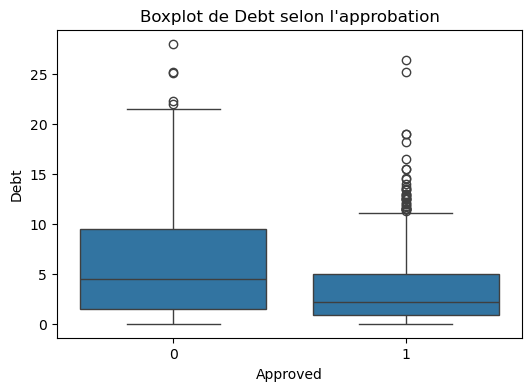

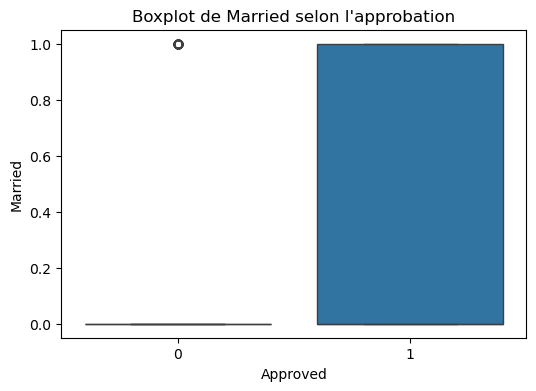

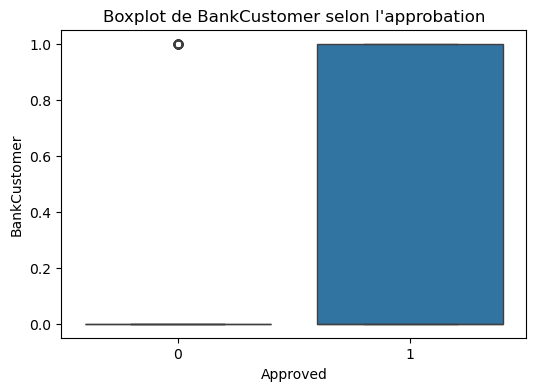

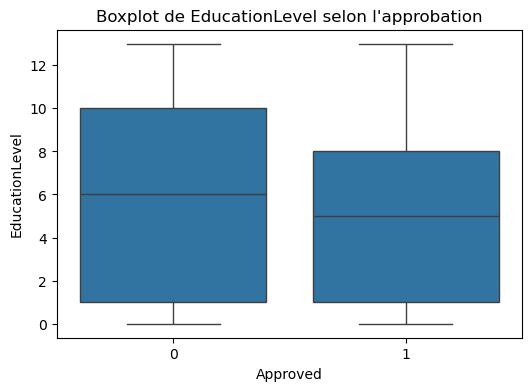

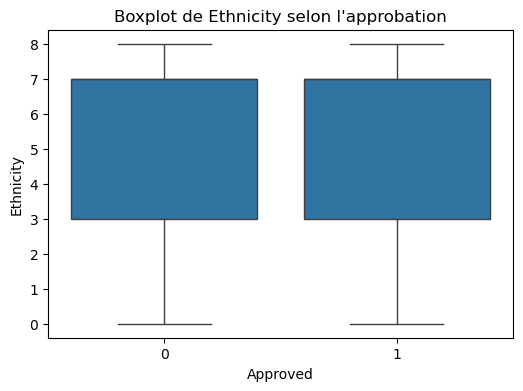

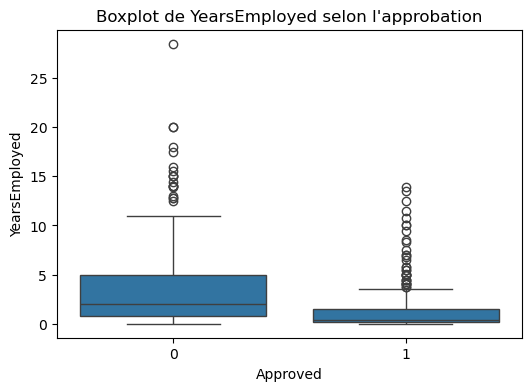

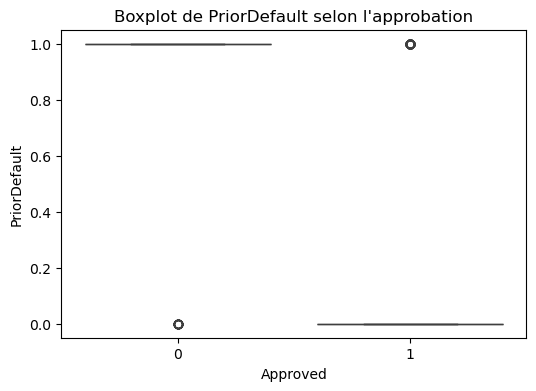

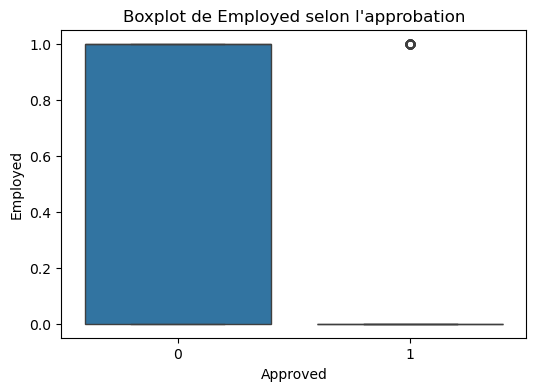

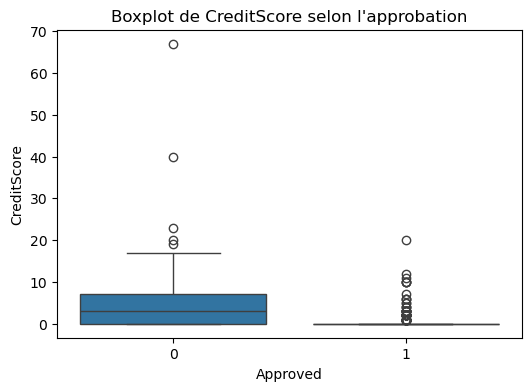

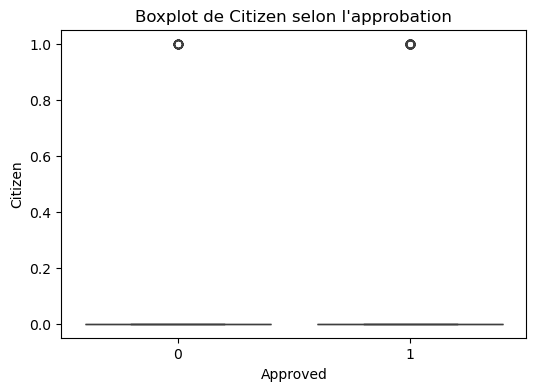

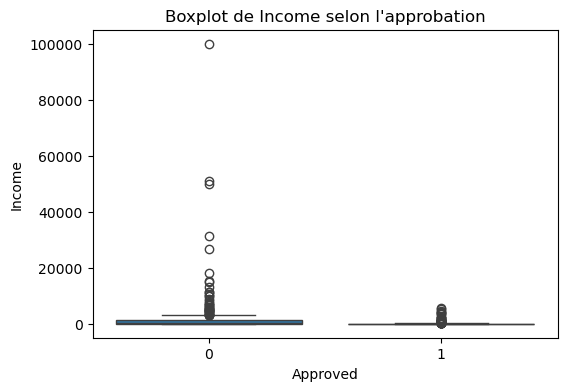

In [95]:
num_cols = df.select_dtypes(include='number').drop('Approved', axis=1).columns

for col in num_cols:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x='Approved', y=col, data=df)
    plt.title(f'Boxplot de {col} selon l\'approbation')
    plt.show()

### Interpretation
1. Ici on peut dire que l'age mediane des gens pour lequel le credit a été est d'environ 31 ans, 
et que la majeur partie des gens auquel on a accordé un credit on entre 24 et 43 ans. 
2. On remarque la majeur partie des gens auxquels la carte est approuvé on entre 1 et 5 ans d'année de travail (yearsEmployed) et que la plupart des refus conecerne des gens qui ont moins 1 an d'experience de travaille.
3. les demandes qui approuvés concerne en majorité les gens qui ont un creditScore entre 0 et 8, quelques individus se demarque avec un cereditScore de 40 allant jusqu'à 67(valeur max d'apres le df.desrcibe()) et peuvent être considéré comme des Outliers et peuvent perturber nos modèles
4. il y a un individue avec un salaire de 100 000, et que c'est très de voir un client avec un salaire supérieur à 4000 $ environs 

## Modélisation 

### Logistic Regression
Car c'est un modèle linéaire qui peut nous permettre de comprendre l’impact de chaque variable sur la probabilité d’approbation.

In [133]:
X = df.drop('Approved', axis=1)
y = df['Approved']

# Standardisation obligatoire pour la régression logistique
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train_lr, y_train_lr)
y_pred_lr = logreg.predict(X_test_lr)

print('Logistic Regression Accuracy:', accuracy_score(y_test_lr, y_pred_lr))
print(classification_report(y_test_lr, y_pred_lr))
print(confusion_matrix(y_test_lr, y_pred_lr))

Logistic Regression Accuracy: 0.8260869565217391
              precision    recall  f1-score   support

           0       0.79      0.87      0.82        97
           1       0.87      0.79      0.83       110

    accuracy                           0.83       207
   macro avg       0.83      0.83      0.83       207
weighted avg       0.83      0.83      0.83       207

[[84 13]
 [23 87]]


### Interpretation 
Après avoir entraîné le modèle de régression logistique, nous avons obtenu une accuracy (précision globale) de 82,6 % sur les données de test. Cela signifie que le modèle a correctement prédit l'étiquette dans environ 83 % des cas.
- pour la classe 0 :
Précision: 0.79  Signifie que sur toutes les prédictions de classe 0, 79% étaient
correctes.
   - Recall : 0.87 Le modèle à capturé 87 % des vrais cas de classe 0.
   - F1-score: 0.82 ceci indique un bon equilibre car cest la moyenne harmonique entre la precision et le rappel 
- pour la classe 1 : (on peut faire une analyse similaire)
   - Précision : 0.87
   - Recall: 0.79
   - F1-score: 0.83   

### Logistic Regressioin avec gridSearch

In [137]:
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline


# === 1. Séparation train / test ==========================
X = df.drop('Approved', axis=1)
y = df['Approved']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

# === 2. Pipeline : scaler + régression ===================
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('clf',    LogisticRegression(max_iter=2000, class_weight='balanced'))
])

# === 3. Grille d'hyper-paramètres ========================
# SAGA est le seul solveur qui prend en charge l1, l2, elastic-net ET none
param_grid = {
    'clf__penalty'   : ['l1', 'l2', 'elasticnet', 'none'],
    'clf__C'         : [0.01, 0.1, 1, 10, 100],
    'clf__l1_ratio'  : [None, 0.25, 0.5, 0.75],   
    'clf__solver'    : ['saga']
}

# === 4. Validation croisée stratifiée ====================
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(
    estimator  = pipe,
    param_grid = param_grid,
    cv         = cv,
    scoring    = 'accuracy',    
    n_jobs     = -1,
    verbose    = 1
)

# === 5. Entraînement =====================================
grid.fit(X_train, y_train)

print("Meilleurs hyper-paramètres :", grid.best_params_)
print("Score CV (accuracy)        :", grid.best_score_)

# === 6. Évaluation sur le jeu de test ====================
y_pred = grid.predict(X_test)

print("Accuracy test              :", accuracy_score(y_test, y_pred))
print("\nClassification report :")
print(classification_report(y_test, y_pred))
print("Matrice de confusion :")
print(confusion_matrix(y_test, y_pred))


Fitting 5 folds for each of 80 candidates, totalling 400 fits


C:\Users\NEW\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
125 fits failed out of a total of 400.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\NEW\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\NEW\anaconda3\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\NEW\anaconda3\Lib\site-packages\sklearn\pipeline.py", line 473, in fit
    self._final_estimator.fit(Xt, y

Meilleurs hyper-paramètres : {'clf__C': 10, 'clf__l1_ratio': None, 'clf__penalty': 'l2', 'clf__solver': 'saga'}
Score CV (accuracy)        : 0.8799613402061857
Accuracy test              : 0.8309178743961353

Classification report :
              precision    recall  f1-score   support

           0       0.78      0.87      0.82        92
           1       0.88      0.80      0.84       115

    accuracy                           0.83       207
   macro avg       0.83      0.83      0.83       207
weighted avg       0.84      0.83      0.83       207

Matrice de confusion :
[[80 12]
 [23 92]]


### Interpretation 
Score en validation croisée (train) : 88%

Score sur jeu de test (test) : 83%

- Le modèle montre une bonne capacité de généralisation, avec une légère baisse de performance entre entraînement et test (88% → 83%), ce qui est normal.
- Précision
   - Approuvé (0) : 78 % des prédictions "Approuvé" étaient correctes.

   - Non approuvé (1) : 88 % des prédictions "Non approuvé" étaient correctes.

- Rappel
   - Approuvé (0) : 87 % des vrais dossiers approuvés ont bien été détectés.

   - Non approuvé (1) : 80 % des vrais non-approuvés ont été bien prédits.

- F1-score
Légèrement meilleur pour les "Non approuvés", ce qui montre un léger avantage du modèle à détecter les refus.

- Matrice de confusion:
  - 80 vrais positifs (Approuvé bien détecté)

  - 92 vrais négatifs (Non approuvé bien détecté)

  - 12 dossiers refusés à tort (faux négatifs) alors le modèle pense qu'ils doivent être non approuvés, mais ils devraient l'être.

  - 23 dossiers acceptés à tort (faux positifs) alors le modèle pense qu'ils doivent être approuvés, mais ils ne le méritent pas.
 
- Le modele identifie bien les dossiers à approuver (classe 0) avec 87 % de rappel

- il est encore meilleur pour dire qu’un dossier ne doit pas être approuvé (88 % de précision pour la classe 1)

### RandomForest avec GridSearchCV
GridASearchCV pour trouvé le model avec les meilleures hyperparamètres en comparant les différentes performances de chaque combinaison grâce à la croosValidation 

In [140]:
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X, y, test_size=0.3, random_state=42)

rf = RandomForestClassifier(random_state=42)
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

grid_search_rf = GridSearchCV(rf, param_grid_rf, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search_rf.fit(X_train_rf, y_train_rf)  




print('Meilleurs paramètres RF:', grid_search_rf.best_params_)
best_rf = grid_search_rf.best_estimator_
model_pickel_rf = best_rf # pour pouvoir sauvegarder le model avec pickle et l'utiliser plus tard
# Sauvegarde dans un fichier .pkl
with open("credit_approval_rf_model.pkl", "wb") as f:
    pickle.dump(model_pickel_rf, f)


y_pred_rf = best_rf.predict(X_test_rf)


print('Accuracy random Forest:', accuracy_score(y_test_rf, y_pred_rf))
print(classification_report(y_test_rf, y_pred_rf))
print(confusion_matrix(y_test_rf, y_pred_rf))

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


C:\Users\NEW\anaconda3\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Meilleurs paramètres RF: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}
Accuracy random Forest: 0.855072463768116
              precision    recall  f1-score   support

           0       0.84      0.86      0.85        97
           1       0.87      0.85      0.86       110

    accuracy                           0.86       207
   macro avg       0.85      0.86      0.85       207
weighted avg       0.86      0.86      0.86       207

[[83 14]
 [16 94]]


##  Interprétation des résultats du modèle Random Forest (avec GridSearchCV)

### Classe 0 = Approuvé

-  Le modèle détecte correctement **86 %** des dossiers à approuver (**rappel**).
-  Parmi les dossiers qu’il approuve, **84 %** sont réellement valides (**précision**).

### Classe 1 = Non approuvé

-  Il détecte **85 %** des mauvais dossiers (**rappel**).
-  Quand il prédit "non approuvé", il se trompe rarement : **87 %** de précision.


### Équilibre du modèle

Le modèle est **bien équilibré**, performant sur les deux classes, **sans biais visible** en faveur de l’une ou l’autre.



###  Analyse des erreurs

-  **14 dossiers approuvés à tort** (faux positifs) : le modèle les considère comme valides, alors qu’ils ne le sont pas.
-  **16 bons dossiers refusés à tort** (faux négatifs) : le modèle a été trop strict et a rejeté des dossiers valides.



### Conclusion

- Le **Random Forest** montre de **très bonnes performances globales**, avec un **équilibre entre précision et rappel** sur les deux classes.
- Il est **plus stable que la régression logistique** sur ce jeu de données.
- Il est **moins sensible à la multicolinéarité** et aux effets d’échelle, ce qui en fait un **bon choix pour une application en production**.



### Importance des variables 
Grace au Random Forest on peut voir l'importance des variables ce qui est tres utile pour l'interpretation et la selection de features pour encore améliorer notre modèle !!!

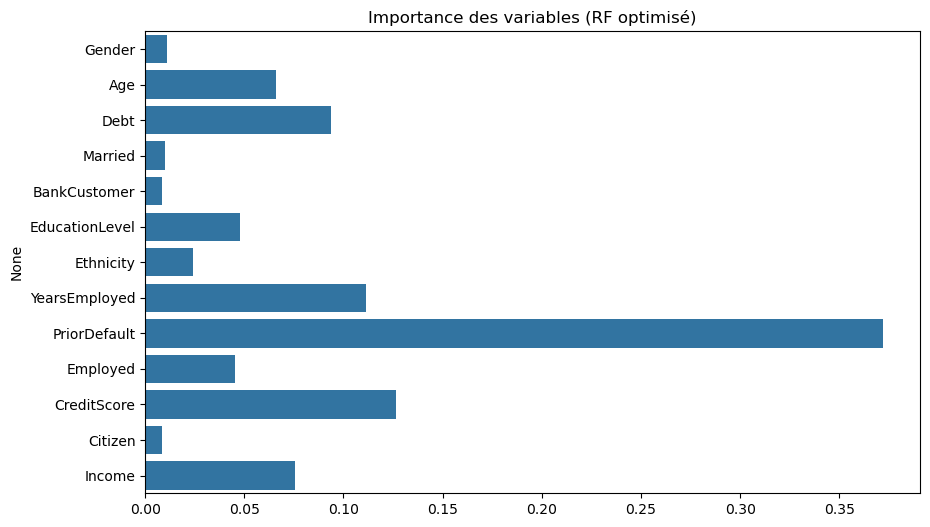

In [143]:
importances = best_rf.feature_importances_
features = X.columns

plt.figure(figsize=(10,6))
sns.barplot(x=importances, y=features)
plt.title('Importance des variables (RF optimisé)')
plt.show()

#### Interpretation:
On peut voir que certaines variables comme Gender, Married, Citizen 

### Comparaison des 2 modèles 
A partir de nos resultats précédent on constate déjà que RandomForest généralise mieux que la Logistic Regression dans ce cas ci !
Confirmons notre analyse avec une courbe ROC :

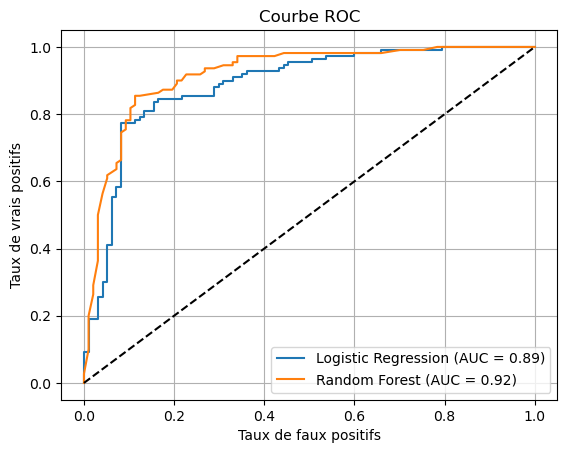

In [146]:
from sklearn.model_selection import  learning_curve
from sklearn.metrics import roc_curve, auc, precision_recall_curve

# Modèles
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier()
}

for name, model in models.items():
    model.fit(X_train_lr, y_train_lr)
    y_proba = model.predict_proba(X_test_lr)[:, 1]  # Probabilité positive

    # Courbe ROC
    fpr, tpr, _ = roc_curve(y_test_lr, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")

# ROC curve plot
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("Taux de faux positifs")
plt.ylabel("Taux de vrais positifs")
plt.title("Courbe ROC")
plt.legend()
plt.grid()
plt.show()

Interpretation: 
- Le modèle de Random Forest a une AUC = 0.92, ce qui signifie qu'il distingue très bien les classes positive et negative.
- Même si la Logistic Regression aussi a un AUC élevé = 0.89, mais elle légèrement moins performante que le Random Forest dans ce cas !

## Déploiement du projet avec le model Random Forest à travers Streamlite.
Création d'un environnement d'exploitation de notre modèle !!! 
(voir le dossier creditCardApproval_App lié a ce projet !)
